# 从零开始的扩散模型

有时，将一件事物简化到最基础的形式有助于深入理解其工作原理。本笔记将从一个“玩具”扩散模型出发，观察各个组成部分如何协同运作，并进一步探讨它们与更复杂实现之间的差异。  

我们将讨论  

- **破坏过程**（向数据逐步注入噪声）  
- **UNet** 的概念，以及如何从零实现一个极简 UNet  
- **扩散模型训练**  
- **采样理论**  

随后，我们会把自己的版本与 `diffusers` 库中的 **DDPM** 实现进行比较，具体包括  

- 迷你 UNet 之外的改进  
- **DDPM 噪声调度**  
- 训练目标的差异  
- **时间步条件化**  
- 不同的 **采样方法**  

本笔记内容较为深入，如果你对从零实现的深度探索兴趣不大，可放心跳过。  

需要注意的是，以下代码主要用于演示，**不建议在生产环境中直接使用**（除非你只是希望在此基础上学习并加以改进）。  

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

d:\Users\yin-pu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 数据集

在这里，我们将使用一个非常小的数据集 **MNIST** 来进行实验。如果你想在保持其他代码不变的前提下，让模型面对稍微更有挑战性的数据集，可以将其替换为 `torchvision.datasets.FashionMNIST`——它可以直接无缝替换。

In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 2, 3, 5, 3, 0, 0, 6])


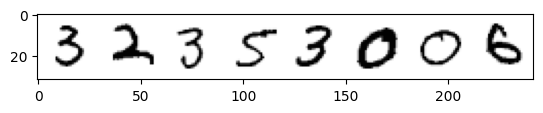

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

每张图像均为 **28×28 像素的灰度手写数字**，像素值范围为 **0 到 1**。


## 破坏过程（Corruption Process）

假设你从未阅读过任何扩散模型论文，只知道这一类模型需要向数据中注入噪声。我们应该怎样动手实现呢？

首先，我们需要一种**简单可控**的方式来调节破坏强度。不妨引入参数 `amount` 表示噪声比例，然后执行下面两步：

```python
noise = torch.rand_like(x)
noisy_x = (1 - amount) * x + amount * noise
```

当 amount = 0 时，noisy_x 与输入 x 完全一致。
当 amount = 1 时，noisy_x 变成纯噪声，看不到任何原始信息。通过这种线性混合，我们既能自由控制噪声占比，也能保证输出依旧位于(0,1)的同一数值区间内。

下面给出一个完整实现（务必留意张量形状，避免广播陷阱）

In [4]:
import torch

def corrupt(x, amount):
    """
    根据给定的 `amount`，将输入张量 `x` 与噪声混合，实现对 `x` 的“损坏”。
    
    参数：
        x (torch.Tensor): 原始输入张量。
        amount (torch.Tensor): 损坏程度张量，值域 [0, 1]，形状为 (batch_size,)。
    
    返回：
        torch.Tensor: 按比例混合后的张量。
    """
    # 生成与 x 同形状的均匀分布随机噪声
    noise = torch.rand_like(x)
    # 将 amount 重塑为 (batch_size, 1, 1, 1)，以便在与 x 同维度时可以正确广播
    amount = amount.view(-1, 1, 1, 1)
    # 返回按比例混合后的结果：保留 x 的部分 + 噪声的部分
    return x * (1 - amount) + noise * amount

并通过可视化结果来验证其按预期运行：

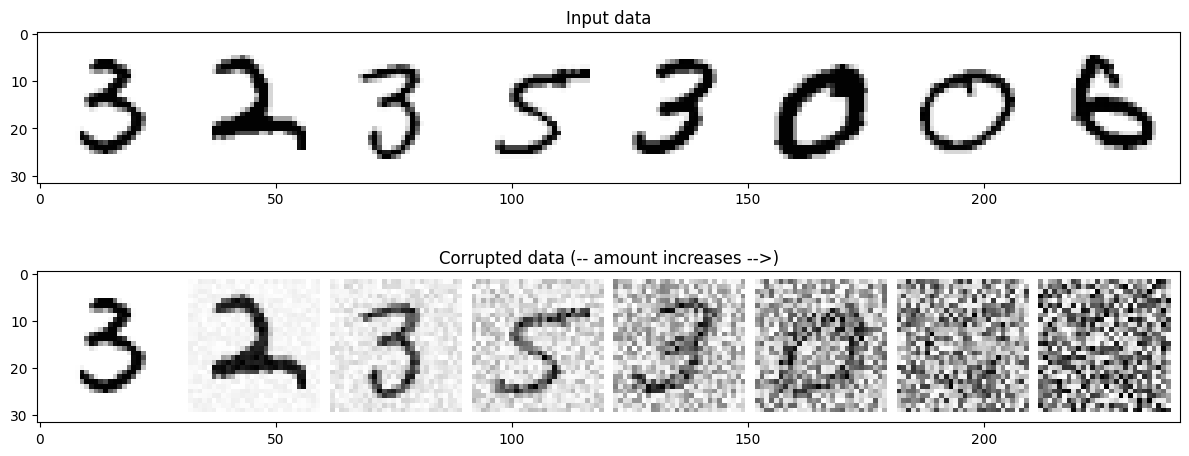

In [5]:
# 绘制输入数据和其损坏版本的对比图
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

# 第一行：显示原始输入数据
axs[0].set_title('Input data')  # 设置子图标题为“输入数据”
# 将批次图像拼接成网格，并取第一张进行灰度显示
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 生成线性递增的噪声强度：从 0（无噪声）到 1（全噪声）
amount = torch.linspace(0, 1, x.shape[0])  # 张量形状为 (batch_size,)
# 对输入数据应用 corrupt 函数，得到带噪声的张量
noised_x = corrupt(x, amount)

# 第二行：显示损坏后的数据（噪声强度从左到右递增）
axs[1].set_title('Corrupted data (-- amount increases -->)')  # 设置子图标题为“损坏数据（噪声强度递增）”
# 将带噪声的图像拼接网格后，取第一张进行灰度显示
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

plt.tight_layout()  # 自动调整子图参数，使图像布局不重叠
plt.show()  # 显示图形

随着 **噪声比例** 接近 1，数据几乎变成了**纯随机噪声**。但在大多数噪声水平下，你仍然可以相当准确地猜出数字。你认为这样的设置已经最优了吗？


## 模型

我们需要一个模型：输入为 **28 像素、带噪声的单通道图像**，输出为 **相同形状** 的预测。最常用的架构是 **UNet**。UNet 最初用于医学影像分割任务 ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)) ，其特点是包含一条“收缩路径”（将特征逐步压缩）和一条“扩张路径”（将特征恢复到原始分辨率），并在对应层之间加入 **跳跃连接**（skip connections），以便在不同分辨率层面传递信息与梯度。

某些 UNet 版本在每个阶段使用复杂的残差或注意力块，但在本“玩具”示例中，我们只实现一个 **极简 UNet**：

- **输入**：单通道 28×28 图像  
- **下采样路径**（`down_layers`）：连续 3 个卷积层，每个卷积后用 **最大池化** 进行下采样  
- **上采样路径**：对应 3 个卷积层，使用 `nn.Upsample` 上采样  
- **跳跃连接**：将下采样层的输出拼接或相加给对应的上采样层  
- 不使用可学习的下采样或上采样层，以保持实现最小化

下面是该架构的通道数示意图（每层输出通道数）：

![unet-model-toy](./assets/unet-model-toy.png)

In [6]:
import torch
import torch.nn as nn

class BasicUNet(nn.Module):
    """一个最简化的 UNet 实现。"""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # 下采样部分的卷积层
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),  # 输入->32 通道
            nn.Conv2d(32, 64, kernel_size=5, padding=2),           # 32->64 通道
            nn.Conv2d(64, 64, kernel_size=5, padding=2),           # 64->64 通道
        ])
        # 上采样部分的卷积层
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),           # 64->64 通道
            nn.Conv2d(64, 32, kernel_size=5, padding=2),           # 64->32 通道
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), # 32->输出通道
        ])
        self.act = nn.SiLU()           # 激活函数 SiLU
        self.downscale = nn.MaxPool2d(2)  # 下采样，尺寸减半
        self.upscale = nn.Upsample(scale_factor=2)  # 上采样，尺寸扩大两倍

    def forward(self, x):
        # 存储跳跃连接的特征
        h = []
        # 下采样编码器
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # 对于前两个下采样层，进行跳跃连接存储和池化
                h.append(x)         # 存储当前层的特征图
                x = self.downscale(x)  # 池化下采样
        
        # 上采样解码器
        for i, l in enumerate(self.up_layers):
            if i > 0:  # 除了第一个上采样层，先进行上采样并添加跳跃连接
                x = self.upscale(x)  # 上采样
                x += h.pop()         # 加上对应编码器的特征图
            x = self.act(l(x))       # 卷积 + 激活
            
        return x  # 输出预测结果

我们可以验证输出的形状与输入相同，正如我们所预期的：

In [7]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

该网络的参数数量略高于 300,000 个：

In [8]:
sum([p.numel() for p in net.parameters()])

309057

您可以尝试更改每一层的通道数，或在不同的架构之间进行替换。

## 训练网络

那么模型究竟应该做什么呢？同样，对于这一点有许多不同的说法，但在本演示中我们采用一个简单的表述：给定被破坏的输入 `noisy_x`，模型应输出它对原始 `x` 的最佳估计。我们将使用均方误差（Mean Squared Error, MSE）将这一估计与真实值进行比较。

我们现在可以尝试训练网络：

- 获取一批数据  
- 随机程度地对其进行破坏  
- 将其输入模型  
- 将模型预测与干净图像进行比较以计算损失  
- 相应地更新模型参数  

请随意修改这些步骤，看看是否能让模型表现得更好！


Finished epoch 0. Average loss for this epoch: 0.025881
Finished epoch 1. Average loss for this epoch: 0.019690
Finished epoch 2. Average loss for this epoch: 0.018182


(0.0, 0.1)

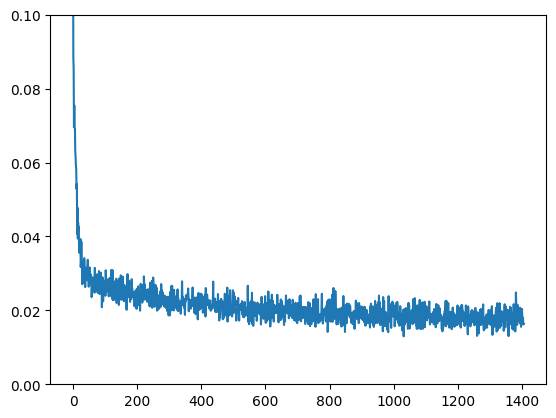

In [9]:
# 数据加载器（可以调整 batch_size）
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 创建训练数据加载器，随机打乱数据

# 训练多少个 epoch
n_epochs = 3

# 创建网络
net = BasicUNet()
net.to(device)  # 将网络移动到指定设备（GPU 或 CPU）

# 损失函数
loss_fn = nn.MSELoss()

# 优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)  # 使用 Adam 优化器，学习率为 1e-3

# 记录每个 batch 的损失值，便于后续查看
losses = []

# 训练循环
for epoch in range(n_epochs):  # 遍历每个 epoch

    for x, y in train_dataloader:  # 遍历训练数据

        # 获取一个批次的数据，并生成对应的带噪声数据
        x = x.to(device)  # 将数据移动到设备
        noise_amount = torch.rand(x.shape[0]).to(device)  # 为每个样本随机生成噪声强度
        noisy_x = corrupt(x, noise_amount)  # 对输入添加噪声

        # 模型前向推理
        pred = net(noisy_x)

        # 计算损失
        loss = loss_fn(pred, x)  # 输出与真实干净数据之间的误差

        # 反向传播并更新模型参数
        opt.zero_grad()  # 清零梯度
        loss.backward()  # 反向传播
        opt.step()  # 更新参数

        # 存储损失值
        losses.append(loss.item())

    # 打印当前 epoch 的平均损失
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# 绘制损失曲线
plt.plot(losses)
plt.ylim(0, 0.1)  # 设置 y 轴范围以更好地观察损失变化

我们可以尝试通过抓取一批数据，对其施加不同程度的噪声破坏，然后查看模型的预测结果：

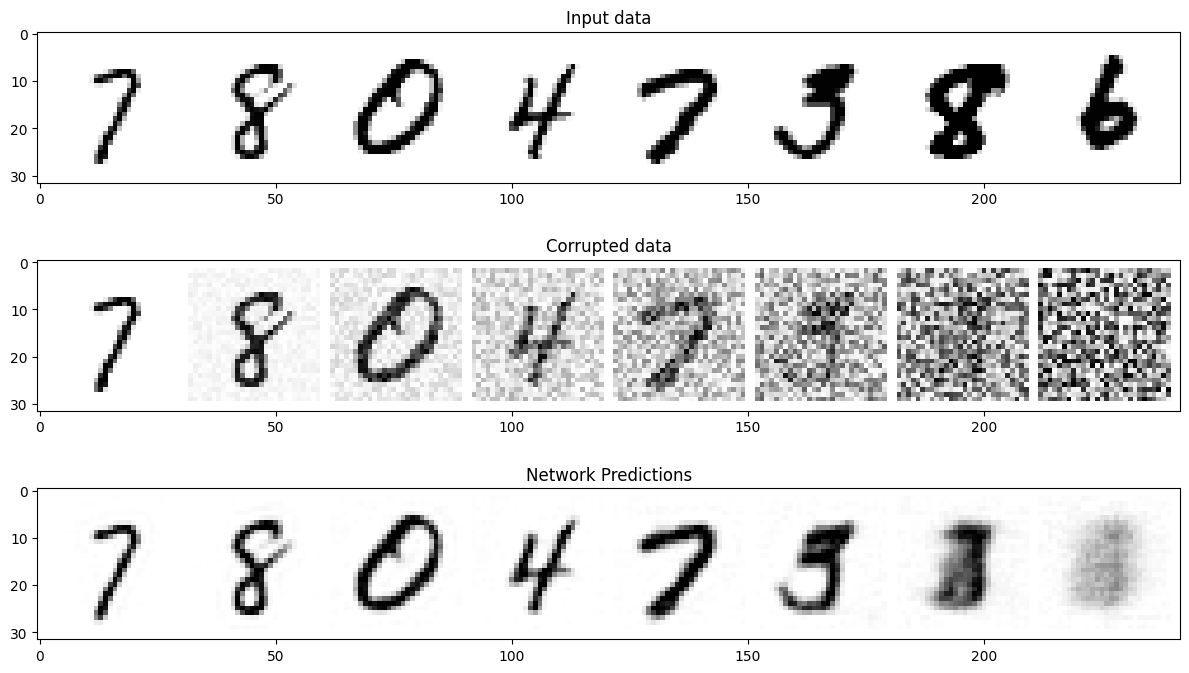

In [15]:
#@markdown 可视化模型在不同噪声强度下的预测效果：

# 获取一批训练数据
x, y = next(iter(train_dataloader))
# 仅使用前8个样本，便于可视化
x = x[:8]

# 生成不同强度的噪声（从0到1）
amount = torch.linspace(0, 1, x.shape[0])  # 左侧强度小，右侧强度大
noised_x = corrupt(x, amount)  # 对输入添加噪声

# 获取模型预测结果
with torch.no_grad():
    preds = net(noised_x.to(device)).cpu()  # 预测

# 可视化：原始输入、添加噪声后的输入 与 模型预测结果
fig, axs = plt.subplots(3, 1, figsize=(12, 7))

axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clamp(0, 1), cmap='Greys')

axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clamp(0, 1), cmap='Greys')

axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clamp(0, 1), cmap='Greys')

plt.tight_layout()
plt.show()


你可以看到，在噪声较小时，模型的预测非常不错！但当噪声水平变得很高时，模型可利用的信息就少得多；当我们把 `amount = 1` 时，模型输出的结果就会是一团模糊的“平均图像”，接近数据集的均值，以此来“押注”输出可能是什么样子……


## 采样

如果在高噪声水平下我们的预测效果不佳，那该如何生成图像呢？

一种思路是：从随机噪声开始，观察模型的预测，但只朝着该预测移动一小步——例如 20% 的距离。此时我们得到一张仍然十分嘈杂、但或许已略含结构信息的图像。将这张图像再次输入模型，获得新的预测。由于起始图像噪声稍低，新的预测应当比第一次更好，于是我们可以依据这次更好的预测再迈出一小步。

重复此过程若干次（如果一切顺利），最终就能得到一张图像！下图示范了仅用 5 步完成这一过程：每一步都展示了模型输入（左）以及模型预测的去噪图像（右）。请注意：尽管模型在第 1 步就已经给出了一幅完全去噪的预测图像，我们仍然**只走了 x 的一小部分**。经过几步迭代，结构逐渐浮现并被细化，最终得到输出。


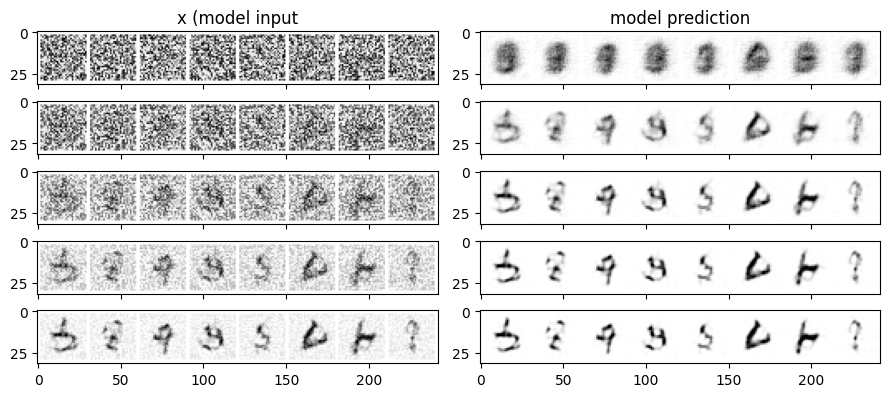

In [17]:
# 设置采样步骤总数
n_steps = 5
# 从随机噪声开始生成8个样本（1通道28x28）
x = torch.rand(8, 1, 28, 28).to(device)
# 记录每一步的输入和模型输出，便于后续可视化
step_history = [x.detach().cpu()]
pred_output_history = []

# 迭代采样过程，共n_steps步
for i in range(n_steps):
    with torch.no_grad(): 
        pred = net(x)      # 模型预测当前x对应的去噪结果x0
    pred_output_history.append(pred.detach().cpu())  # 保存预测结果
     # 本次迭代向预测移动的比例  
    mix_factor = 1 / (n_steps - i)
    # 按比例在输入与预测之间插值
    x = x * (1 - mix_factor) + pred * mix_factor
    step_history.append(x.detach().cpu())  # 保存更新后的x

# 可视化每一步的输入和对应的模型预测
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title('x (model input')
axs[0, 1].set_title('model prediction')
for i in range(n_steps):
    # 将第i步的输入和预测结果拼接成网格并展示
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clamp(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clamp(0, 1), cmap='Greys')

plt.tight_layout()
plt.show()

我们可以将过程拆分为更多步骤，这样或许能得到更好的图像：

(-0.5, 241.5, 241.5, -0.5)

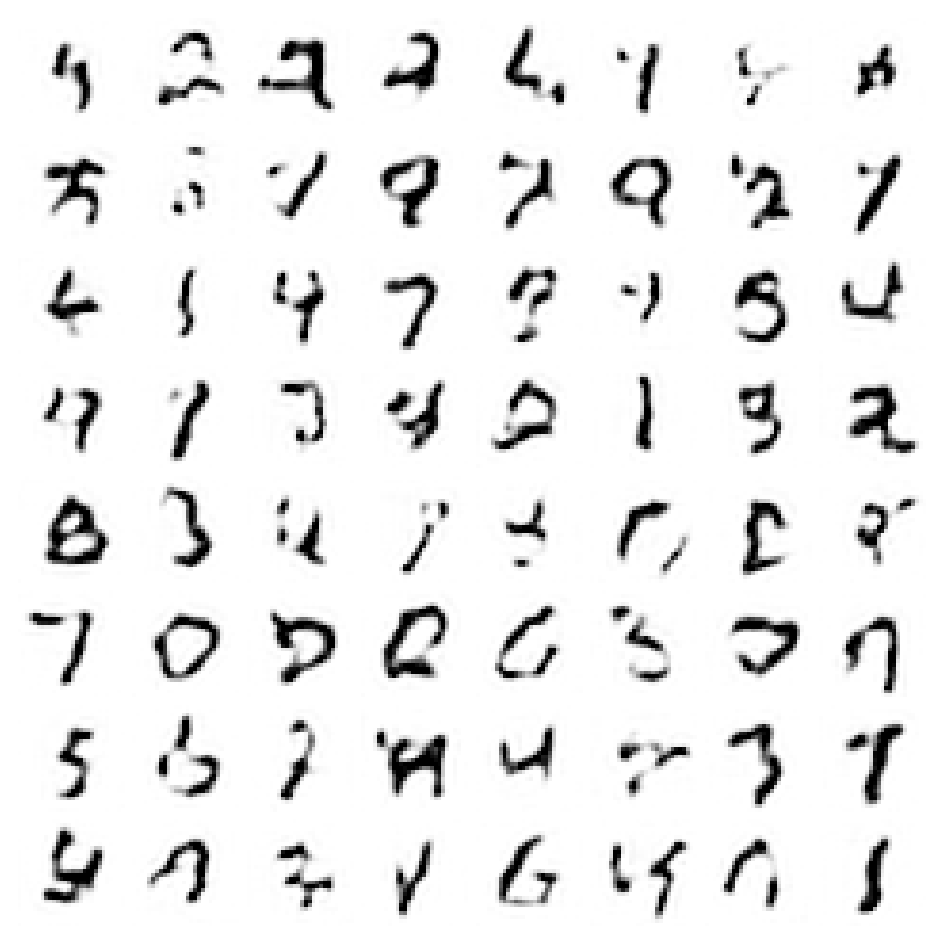

In [18]:
# 使用 40 步采样展示更多生成效果
n_steps = 40  # 采样步数
x = torch.rand(64, 1, 28, 28).to(device)  # 从噪声开始
for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)  # 预测去噪结果
    mix_factor = 1 / (n_steps - i)  # 随步数递增混合因子
    x = x * (1 - mix_factor) + pred * mix_factor  # 将预测结果与当前 x 融合

# 可视化 8x8 网格上的生成图像
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1)
ax.imshow(grid, cmap='Greys')
ax.axis('off')  # 隐藏坐标轴

效果并不算完美，但已经能看到一些可辨识的数字！你可以尝试延长训练时间（比如 10 或 20 个 epoch），并调整模型配置、学习率、优化器等超参数。此外，如果想挑战更难的数据集，只需一行代码就能把数据集切换为 FashionMNIST。


## 与 DDPM 的比较

在本节中，我们将看看我们的本次实现与另一份notebook（[Introduction to Diffusers](./01_introduction_to_diffusers.ipynb)）中基于 DDPM 论文的方法有何不同。

我们会看到：

* diffusers 中的 `UNet2DModel` 比我们的 BasicUNet 更为先进  
* 破坏（加噪）过程的处理方式不同  
* 训练目标不同，需要预测“噪声”而非去噪后的图像  
* 模型通过时间步条件（将 t 作为 forward 方法的额外参数）来获知噪声量  
* 还有多种采样策略可选，它们应当比我们上面朴素的实现效果更好  

自 DDPM 论文发表以来，已经有许多改进被提出，但本示例希望能说明不同的设计决策。读完之后，你或许会感兴趣去深入阅读论文《[Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)》，其中对所有这些组件进行了详细探索，并给出了如何获得最佳性能的新建议。

如果你觉得这些内容过于技术化或过于复杂，也别担心！完全可以跳过本笔记本的剩余部分，或者留到哪天有空再看。


### UNet

diffusers 的 **UNet2DModel** 相比我们之前的 BasicUNet 具有多项改进：

* **GroupNorm**：对每个模块的输入进行组归一化  
* **Dropout** 层：使训练过程更平滑  
* **每个 block 内多个 ResNet 层**（当 `layers_per_block` 不为 1 时）  
* **注意力机制**（通常仅在低分辨率 block 中使用）  
* **按时间步进行条件化**  
* **具备可学习参数的下采样与上采样 block**  

下面我们来创建并查看一个 **UNet2DModel**：


In [19]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=28,           # 目标图像分辨率
    in_channels=1,            # 输入通道数，灰度图像为 1，彩色图像 (RGB) 为 3
    out_channels=1,           # 输出通道数
    layers_per_block=2,       # 每个 UNet 模块中使用的 ResNet 层数
    block_out_channels=(32, 64, 64),  # 每个模块输出通道数，与基础 U-Net 示例相匹配
    down_block_types=( 
        "DownBlock2D",        # 常规模块下采样 ResNet 模块
        "AttnDownBlock2D",    # 带空间自注意力的下采样 ResNet 模块
        "AttnDownBlock2D",    # 带空间自注意力的下采样 ResNet 模块
    ), 
    up_block_types=(
        "AttnUpBlock2D",      # 带空间自注意力的上采样 ResNet 模块
        "AttnUpBlock2D",      # 带空间自注意力的上采样 ResNet 模块
        "UpBlock2D",          # 常规模块上采样 ResNet 模块
    ),
)

# 打印模型结构
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

正如你所见，模型复杂了不少！它的参数量也比我们的 BasicUNet 大得多：

In [21]:
sum([p.numel() for p in model.parameters()])

1707009

我们可以在保持其余流程不变的情况下，用这个模型替换原始模型来复现上述训练过程。需要注意的是，模型现在既要接收 `x`，也要接收 `timestep`。在下面的示例中，为了证明即便 **不** 依赖时间步条件也能正常工作，并简化采样代码，我始终传入 `t = 0`；不过你也可以尝试传入 `(amount * 1000)`，将噪声强度映射到等价的时间步。


d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\models\attention_processor.py:3317: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


Finished epoch 0. Average loss for this epoch: 0.019753
Finished epoch 1. Average loss for this epoch: 0.012816
Finished epoch 2. Average loss for this epoch: 0.011690


Text(0.5, 1.0, '生成的样本')

d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\Users\yin-pu\miniconda3\Lib\site-packages\IPython\core\py

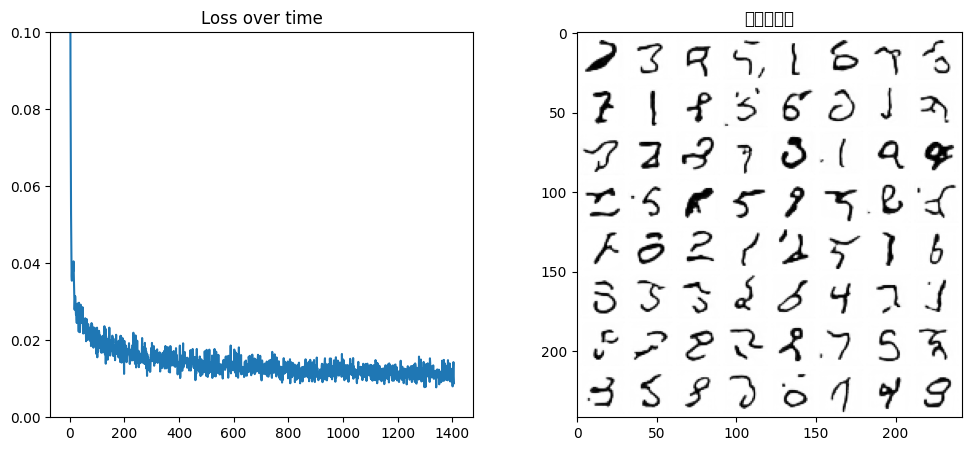

In [ ]:
# 数据加载器（你可以调整 batch 大小）
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 运行多少个 epoch（遍历数据的次数）
n_epochs = 3

# 创建网络
net = UNet2DModel(
    sample_size=28,      # 目标图像分辨率
    in_channels=1,       # 输入通道数，RGB 图像为 3
    out_channels=1,      # 输出通道数
    layers_per_block=2,  # 每个 UNet 模块中 ResNet 层数
    block_out_channels=(32, 64, 64),  # 与基础 UNet 示例大致匹配
    down_block_types=(
        "DownBlock2D",       # 普通 ResNet 下采样模块
        "AttnDownBlock2D",   # 带空间自注意力的下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",     # 带空间自注意力的上采样模块
        "UpBlock2D",         # 普通 ResNet 上采样模块
    ),
)
net.to(device)

# 损失函数
loss_fn = nn.MSELoss()

# 优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# 记录损失值以便后续查看
losses = []

# 训练循环
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # 获取数据并生成带噪声的版本
        x = x.to(device)  # 将数据放到 GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # 随机选择噪声强度
        noisy_x = corrupt(x, noise_amount)  # 创建带噪声的 x

        # 获取模型预测
        pred = net(noisy_x, 0).sample  # 始终使用时间步 0，并添加 .sample

        # 计算损失
        loss = loss_fn(pred, x)  # 输出与真实“干净”x 的差距

        # 反向传播并更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 存储损失值
        losses.append(loss.item())

    # 打印本轮的平均损失
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# 绘制损失曲线和一些生成样本
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 损失曲线
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# 生成样本
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # 从高噪声到低噪声
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples')


这看起来比我们第一组结果要好得多！你可以尝试调整 UNet 的配置或延长训练时间，以取得更好的性能。


### 破坏过程（Corruption Process）

DDPM 论文描述了一种破坏过程，在每一个“时间步”都会加入少量噪声。给定某时间步的 $x_{t-1}$，我们可以得到下一步（噪声略高一点）的 $x_t$：

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t}\,\mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod_{t=1}^T q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

也就是说，我们先将 $x_{t-1}$ 按 $\sqrt{1 - \beta_t}$ 缩放，再加上按 $\beta_t$ 缩放的噪声。$\beta_t$ 按某种时间表（schedule）为每个时间步定义，用来控制每一步加入多少噪声。不过，我们并不一定要真的执行 500 次操作来得到 $x_{500}$；因此还有一个公式，可以在已知 $x_0$ 的情况下直接得到任意时间步的 $x_t$：

$
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}\!\bigl(\mathbf{x}_t;\,
\sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
\sqrt{1 - \bar{\alpha}_t}\,\mathbf{I}\bigr)
$

其中 $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$，而 $\alpha_i = 1 - \beta_i$。

数学符号看起来总是很吓人！好在调度器（scheduler）会帮我们处理所有这些（取消注释下一单元格即可查看代码）。我们可以绘制 $\sqrt{\bar{\alpha}_t}$（代码标签为 `sqrt_alpha_prod`）与 $\sqrt{1 - \bar{\alpha}_t}$（标签为 `sqrt_one_minus_alpha_prod`），以观察在不同时间步中输入 (x) 和噪声是如何被缩放并混合的：


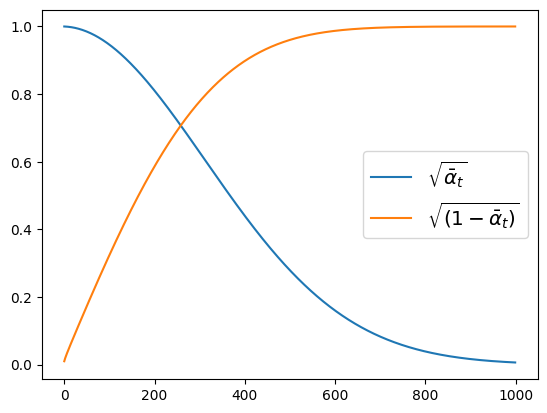

In [23]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

最开始，带噪声的 $\mathbf{x}$ 几乎完全就是原始 $\mathbf{x}$（因为 $\sqrt{\bar{\alpha}_t} \approx 1$），但随着时间推移，$\mathbf{x}$ 的贡献逐渐降低，噪声成分则不断增加。与我们之前根据 `amount` 对 $\mathbf{x}$ 和噪声做线性混合的方式不同，这里噪声上升得更快。我们可以在一些数据上将其可视化：



X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

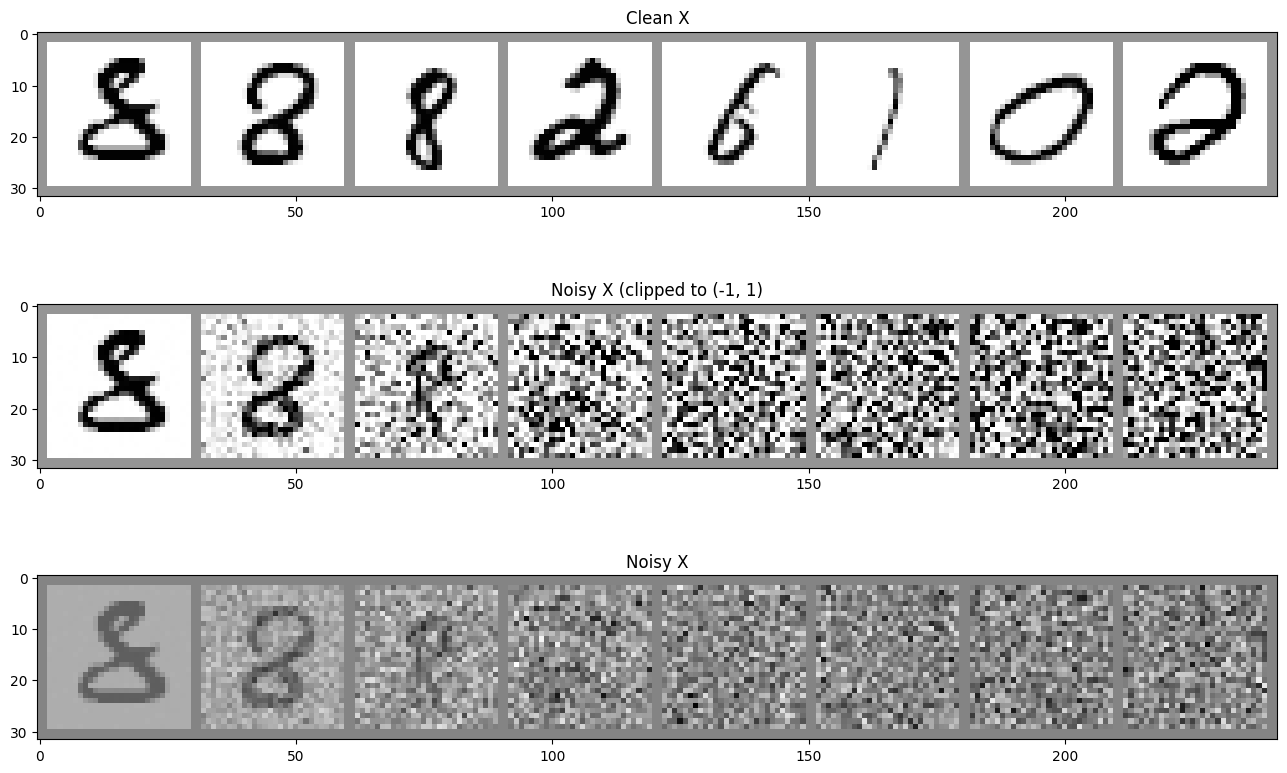

In [24]:
# 为一批图像加噪以查看效果
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1.  # 映射到 (-1, 1)
print('X shape', xb.shape)

# 显示干净输入
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# 使用调度器添加噪声
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << 注意：使用 randn 而非 rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# 显示加噪结果（裁剪与未裁剪）
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap='Greys')
axs[2].set_title('Noisy X')

另一个需要注意的细节：DDPM 版本加入的噪声来自高斯分布（均值 0，标准差 1，由 `torch.randn` 生成），而在最初的 `corrupt` 函数中，我们使用的是 0 到 1 之间的均匀噪声（由 `torch.rand` 生成）。通常来说，对训练数据进行归一化也是有必要的。在另一个 Notebook 中，你会看到在数据变换列表里使用了 `Normalize(0.5, 0.5)`，它将图像数据从区间 (0, 1) 映射到 (-1, 1)。在本 Notebook 中我们没有这样做，但上面的可视化单元格加入了这一步，以便更准确地进行缩放和可视化。


### 训练目标

在我们的玩具示例中，模型尝试预测去噪后的图像。而在 DDPM 以及许多其他扩散模型实现中，模型预测的是破坏过程中所加入的噪声（即**未经任何缩放、方差为 1 的原始噪声**）。代码大致如下：

```python
noise = torch.randn_like(xb) # 注意是randn，而不是rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise 作为预测目标
```

你也许会认为，预测噪声（从而推断出去噪后的图像）与直接预测去噪图像是等价的。那么为什么要偏向其中一种做法——难道只是出于数学上的便利吗？

其实这里还有一层微妙差别：在训练过程中，我们会在**不同（随机选择）的时间步**上计算损失。不同的目标函数会导致这些损失被“隐式”地赋予不同权重，其中**预测噪声**的做法会对**低噪声水平**赋予更大的权重。你可以通过采用更复杂的目标函数来改变这种“隐式损失权重”；也可以选择一种噪声调度，使得高噪声水平的样本比例更高；或者让模型预测一种“速度” $v$（它是图像和噪声按噪声水平组合而成，参见 *Progressive Distillation for Fast Sampling of Diffusion Models*）；又或者依照一定理论，让模型预测噪声但再按噪声大小对损失进行缩放（参见 *Perception Prioritized Training of Diffusion Models*），或基于实验找出对模型最具信息量的噪声水平（参见 *Elucidating the Design Space of Diffusion-Based Generative Models*）。**简言之：目标函数的选择会影响模型性能，而“最佳”方案仍是活跃的研究课题。**

目前，**预测噪声**（在一些资料中记作 $\epsilon$ 或 `eps`）仍是主流做法，但随着研究进展，未来库中很可能会支持更多目标函数，并在不同场景下得到应用。


### 时间步条件化（Timestep Conditioning）

UNet2DModel 会同时接收 **x** 与 **timestep** 两个输入。其中，**timestep** 会被转换成嵌入向量，并在模型的多个位置注入。

其理论依据是：如果模型知道当前的噪声水平，就能更好地执行去噪任务。虽然理论上可以在没有时间步条件化的情况下训练模型，但实证研究显示，在某些场景下加入这一机制可以提升性能。因此，至少在现有文献和主流实现中，时间步条件化通常被保留。


### 采样

在已经能够估计输入噪声（或直接预测去噪结果）的模型基础上，我们该如何生成新的图像？

我们可以直接输入纯噪声，并指望模型一步就给出理想的去噪结果。然而，正如上面的实验所示，这通常并不奏效。因此，更可靠的方法是依据模型的预测采取多次较小的更新步骤，逐步去除噪声。

具体该怎样迈出这些步骤，则取决于所选的采样方法。这里不深入理论，仅列出几个关键设计问题：

- **步长应设多大？** 换言之，应遵循怎样的「噪声调度」（noise schedule）？  
- **是否只依赖模型当前预测来更新**（如 DDPM、DDIM 等）？**是否多次调用模型以估计高阶梯度**，从而进行更大、精确度更高的更新（高阶方法或某些离散 ODE 求解器）？又或是**保留过去预测的历史**，以更好地指导当前更新（线性多步法与 ancestral 采样器）？  
- **是否再注入额外噪声**（有时称为 *churn*）以增加采样过程的随机性，还是保持完全确定性？许多采样器通过参数（例如 DDIM 采样器中的 `eta`）来控制这一点，使用户可以自行选择。  

扩散模型采样方法的研究正迅速发展，新的算法不断被提出，可在更少步骤内找到更优解。勇于探索的读者不妨浏览 diffusers 库中的各类采样器实现源码（[查看代码](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers)），或查阅其[官方文档](https://huggingface.co/docs/diffusers/api/schedulers/overview)，其中常附带相关论文链接。
